In [1]:
!pip install pytorch-tabnet

     |████████████████████████████████| 829 kB 714 kB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=575cc758e099001c1c4e9e5c283ff67344cab3171e9c42bd1a9512643cfe538d
  Stored in directory: /opt/ml/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future


In [111]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [112]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

In [113]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))


In [114]:
data = pd.read_csv("../input/train.csv", parse_dates=["order_date"])
#quantity 이상치 튜플 (74315개 구매직후 환불한)2개 제거
data=data.drop([433791,433796])
# #price 이상치 튜플 (1000원짜리 60개사서 한번에 64300.5의 price로 환불한)2개 기록 제거
# data=data.drop([553676,553686])
#뒤의 색상 option 제거
data['product_id']=data['product_id'].astype(str).map(lambda x : x if x.isdigit() else x[:-1])

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780500 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780500 non-null  object        
 1   product_id   780500 non-null  object        
 2   description  780500 non-null  object        
 3   quantity     780500 non-null  int64         
 4   order_date   780500 non-null  datetime64[ns]
 5   price        780500 non-null  float64       
 6   customer_id  780500 non-null  int64         
 7   country      780500 non-null  object        
 8   total        780500 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 59.5+ MB


In [116]:
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

In [117]:
def feature_engineering1(df, year_month):
    df = df.copy()
    df2=df.copy()
    #customer_id 기준으로 group by 후 total,quantity, price의 누적합 계산
    df['cumsum_total_by_cust_id'] = df.groupby(['customer_id'])['total'].cumsum()
    df['cumsum_quantity_by_cust_id'] = df.groupby(['customer_id'])['quantity'].cumsum()
    df['cumsum_price_by_cust_id'] = df.groupby(['customer_id'])['price'].cumsum()
    #product_id 기준으로 group by 후 total,quantity, price의 누적합 계산
    df['cumsum_total_by_product_id'] = df.groupby(['product_id'])['total'].cumsum()
    df['cumsum_quantity_by_product_id'] = df.groupby(['product_id'])['quantity'].cumsum()
    df['cumsum_price_by_product_id'] = df.groupby(['product_id'])['price'].cumsum()
    #order_id 기준으로 group by 후 total,quantity, price의 누적합 계산
    df['cumsum_total_by_order_id'] = df.groupby(['order_id'])['total'].cumsum()
    df['cumsum_quantity_by_order_id'] = df.groupby(['order_id'])['quantity'].cumsum()
    df['cumsum_price_by_order_id'] = df.groupby(['order_id'])['price'].cumsum()
    
    #month, year_month 추가
    df['month']=df['order_date'].dt.month
    df['year_month']=df['order_date'].dt.strftime('%Y-%m')
    
    #description 마지막 단어로 요약
    df['desc_summary']=df['description'].map(lambda x :x.split()[-1])
    #diff feature 생성
    df['order_ts']=df['order_date'].astype(np.int64)
    df['order_ts_diff']=df.groupby(['customer_id'])['order_ts'].diff()
    df['quantity_diff']=df.groupby(['customer_id'])['quantity'].diff()
    df['price_diff']=df.groupby(['customer_id'])['price'].diff()
    df['total_diff']=df.groupby(['customer_id'])['total'].diff()
    
    #마지막이 환불인 기록 제거, 사람별로 last order 피처 생성
    df2=df2[~df2['order_id'].str.contains('C')]
    df['last_order_ts']=df2['order_date'].astype(np.int64)
    df['last_order_ts_diff']=df.groupby(['customer_id'])['last_order_ts'].diff()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    #percent over 300 피처 사람별로 생성, 
    train_po3=train.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    test_po3=test.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    train_po3['o3']=train_po3.agg({'total': lambda x :1 if x>300 else 0})
    test_po3['o3']=test_po3.agg({'total': lambda x :1 if x>300 else 0})
    # num_whole=po3.groupby(['customer_id'])['o3'].agg('count')
    tr_absolute_po3=round(train_po3.groupby(['customer_id'])['o3'].agg('mean'),2).values[:].squeeze()
    te_absolute_po3=round(test_po3.groupby(['customer_id'])['o3'].agg('mean'),2).values[:].squeeze()
    tr_num_one=train_po3.groupby(['customer_id'])['o3'].agg('sum')
    te_num_one=test_po3.groupby(['customer_id'])['o3'].agg('sum')
    tr_relative_po3=round(tr_num_one/24,2).values[:].squeeze()
    te_relative_po3=round(te_num_one/24,2).values[:].squeeze()
    
    #사용기간 구매금액의 평균
    tr_usage_total_mean=train_po3.groupby(['customer_id']).agg({'total': ['mean','max','min','sum','count','std','skew']})
    te_usage_total_mean=test_po3.groupby(['customer_id']).agg({'total': ['mean','max','min','sum','count','std','skew']})
    tr_usage_total_mean.columns=['ym-total-mean','ym-total-max','ym-total-min','ym-total-sum','ym-total-count','ym-total-std','ym-total-skew']
    te_usage_total_mean.columns=['ym-total-mean','ym-total-max','ym-total-min','ym-total-sum','ym-total-count','ym-total-std','ym-total-skew']
    tr_usage_total_mean['ym-total-std'].fillna(0.0, inplace=True) 
    tr_usage_total_mean['ym-total-skew'].fillna(0.0, inplace=True) 
    te_usage_total_mean['ym-total-std'].fillna(0.0, inplace=True) 
    te_usage_total_mean['ym-total-skew'].fillna(0.0, inplace=True) 
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    train_label['absolute_po300']=tr_absolute_po3
    train_label['relative_po300']=tr_relative_po3
    test_label['absolute_po300']=te_absolute_po3
    test_label['relative_po300']=te_relative_po3
    train_label=train_label.merge(tr_usage_total_mean,on='customer_id',how='left')
    test_label=test_label.merge(te_usage_total_mean,on='customer_id',how='left')
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    agg_dict = {
        'quantity': agg_func,
        'price': agg_func,
        'total': agg_func,
        'cumsum_total_by_cust_id': agg_func,
        'cumsum_quantity_by_cust_id': agg_func,
        'cumsum_price_by_cust_id': agg_func,
        'cumsum_total_by_product_id': agg_func,
        'cumsum_quantity_by_product_id': agg_func,
        'cumsum_price_by_product_id': agg_func,
        'cumsum_total_by_order_id': agg_func,
        'cumsum_quantity_by_order_id': agg_func,
        'cumsum_price_by_order_id': agg_func,
        'order_id': ['nunique'],
        'product_id': ['nunique'],
        'month' : [lambda x:x.value_counts().index[0]],
        'year_month':[lambda x:x.value_counts().index[0]],
        'desc_summary' : [lambda x:x.value_counts().index[0]],
        'order_ts' : ['first','last'],
        'order_ts_diff' : agg_func,
        'last_order_ts' : ['first','last'],
        'last_order_ts_diff' : agg_func,
        'quantity_diff' : agg_func,
        'price_diff' : agg_func,
        'total_diff' : agg_func,
    }
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_dict)

        new_cols = []
        for col in agg_dict.keys():
            for stat in agg_dict[col]:
                if type(stat) is str:
                    new_cols.append(f'{col}-{stat}')
                else:
                    new_cols.append(f'{col}-mode')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    #agg취한 값들이 feature가 된다
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_dict)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')
    
    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

In [118]:
train, test, y, features = feature_engineering1(data, '2011-12')

categorical feature: ['year_month-mode', 'desc_summary-mode']
x_tr.shape (5722, 140) , x_te.shape (5914, 140)


In [72]:
features

Index(['o3_x', 'o3_y', 'quantity-mean', 'quantity-max', 'quantity-min',
       'quantity-sum', 'quantity-count', 'quantity-std', 'quantity-skew',
       'price-mean',
       ...
       'price_diff-count', 'price_diff-std', 'price_diff-skew',
       'total_diff-mean', 'total_diff-max', 'total_diff-min', 'total_diff-sum',
       'total_diff-count', 'total_diff-std', 'total_diff-skew'],
      dtype='object', length=130)

In [119]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
import torch.nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
optimizer = torch.optim.Adam

## Supervised learning

In [145]:
clf = TabNetClassifier(
    optimizer_fn=optimizer,
    optimizer_params=dict(lr=0.06),
    scheduler_params={"factor":0.5, # how to use learning rate scheduler
                      "patience":3},
#     scheduler_params={"optimizer":optimizer_fn, "factor":0.9, "patience":10}
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=train[features].values, y_train=y,
    eval_set=[(train[features].values, y)], # (X_valid, y_valid)], 
    eval_name=[('train' , 'valid')], #
    eval_metric=['auc'],
    loss_fn= None,
    weights=0,
    max_epochs = 100,
    patience = 10,
    batch_size = 64, 
    virtual_batch_size = 64,
    num_workers=2,
    drop_last=False,
    callbacks=None,
    pin_memory=True,
    from_unsupervised=None,
)

Device used : cuda
epoch 0  | loss: 0.49112 | ('train', 'valid')_auc: 0.78698 |  0:00:04s
epoch 1  | loss: 0.43835 | ('train', 'valid')_auc: 0.78894 |  0:00:08s
epoch 2  | loss: 0.4248  | ('train', 'valid')_auc: 0.79272 |  0:00:13s
epoch 3  | loss: 0.42184 | ('train', 'valid')_auc: 0.78799 |  0:00:17s
epoch 4  | loss: 0.41968 | ('train', 'valid')_auc: 0.79935 |  0:00:22s
epoch 5  | loss: 0.41053 | ('train', 'valid')_auc: 0.80115 |  0:00:26s
epoch 6  | loss: 0.41301 | ('train', 'valid')_auc: 0.80389 |  0:00:30s
epoch 7  | loss: 0.40917 | ('train', 'valid')_auc: 0.81114 |  0:00:34s
epoch 8  | loss: 0.41224 | ('train', 'valid')_auc: 0.80169 |  0:00:39s
epoch 9  | loss: 0.41335 | ('train', 'valid')_auc: 0.80225 |  0:00:44s
epoch 10 | loss: 0.41112 | ('train', 'valid')_auc: 0.80203 |  0:00:49s
epoch 11 | loss: 0.41001 | ('train', 'valid')_auc: 0.80723 |  0:00:53s
epoch 12 | loss: 0.40954 | ('train', 'valid')_auc: 0.80762 |  0:00:58s
epoch 13 | loss: 0.40645 | ('train', 'valid')_auc: 0.80674

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136]),
 <a list of 137 Text xticklabel objects>)

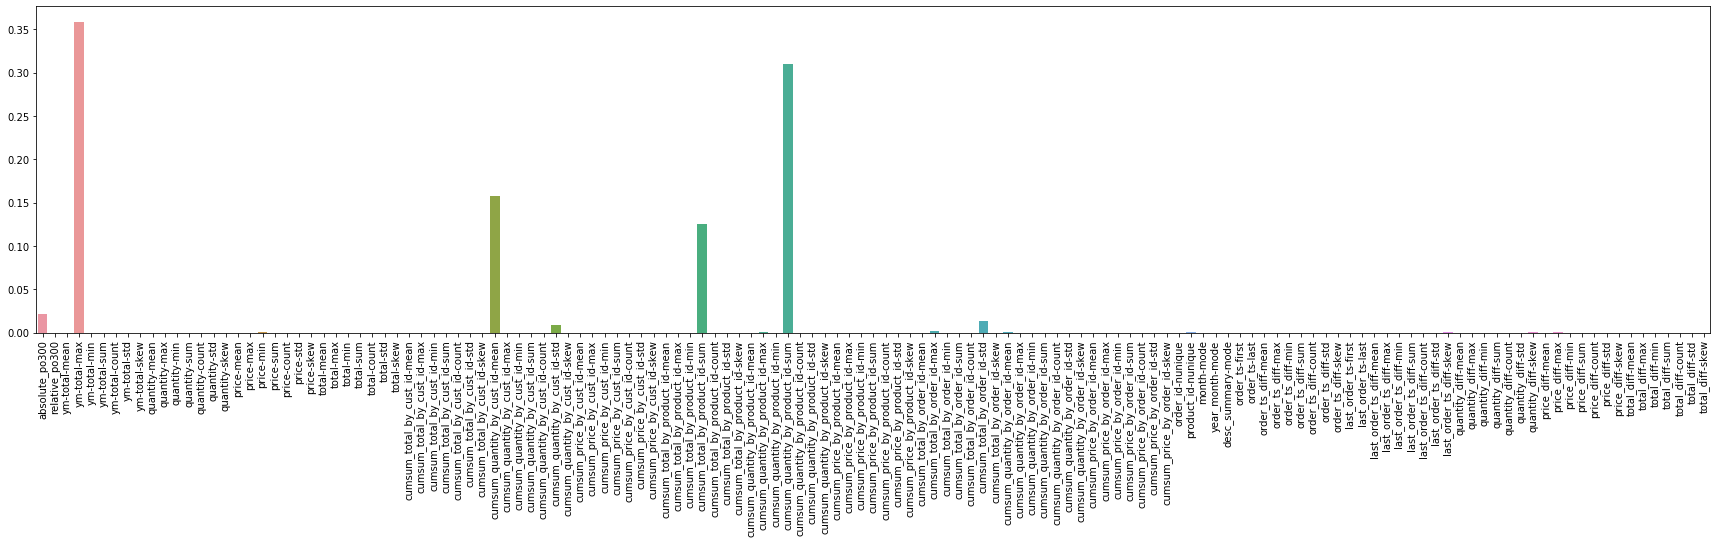

In [149]:
plt.figure(figsize=(30, 6))
sns.barplot(x=features, y=clf.feature_importances_)
plt.xticks(rotation =90)

In [28]:
explain_matrix, masks = clf.explain(test[features].values)

In [29]:
explain_matrix.shape

(5914, 130)

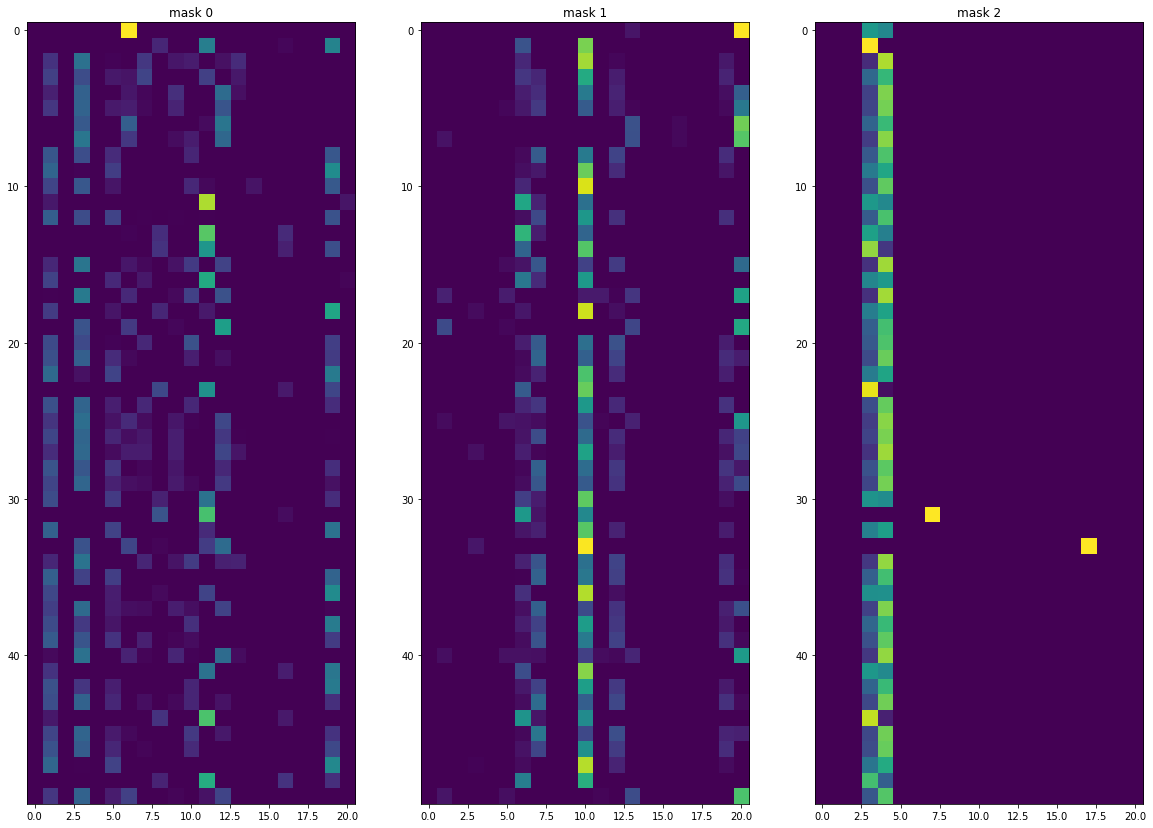

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50]) # 50개 데이터만 제한적으로 열람
    axs[i].set_title(f"mask {i}")

In [ ]:
features

Index(['quantity-mean', 'quantity-max', 'quantity-min', 'quantity-sum',
       'quantity-count', 'quantity-std', 'quantity-skew', 'price-mean',
       'price-max', 'price-min', 'price-sum', 'price-count', 'price-std',
       'price-skew', 'total-mean', 'total-max', 'total-min', 'total-sum',
       'total-count', 'total-std', 'total-skew'],
      dtype='object')

## Semi-supervised learning Tabnet

In [ ]:

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.3),
    mask_type='sparsemax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=train[features].values,
    # eval_set=[X_valid],
    pretraining_ratio=0.8,
)

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.3),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=train[features].values, y_train=y,
    eval_set=[(train[features].values, y)], # , (X_valid, y_valid)
    eval_name=['train'], # , 'valid'
    eval_metric=['auc'],
    loss_fn=None,
    weights=0,
    max_epochs=100,
    patience=20,
    batch_size=16,
    virtual_batch_size=16,
    num_workers=4,
    drop_last=False,
    callbacks=None,
    pin_memory=True,
    from_unsupervised=unsupervised_model
)

In [147]:
pred = clf.predict_proba(test[features].values)

In [ ]:
import seaborn as sns

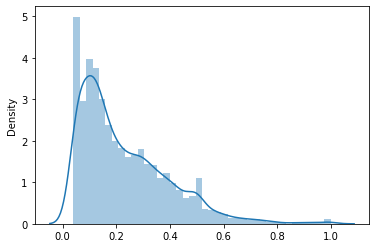

In [148]:
sns.distplot(pred[:, 1])

In [ ]:
sub = pd.read_csv('./boostcamp_source/input/sample_submission.csv')

In [ ]:
sub['probability'] = pred[:, 1]

In [ ]:
sub.head()

,customer_id,probability
0,12346,0.527550
1,12347,0.453751
2,12348,0.226154
3,12349,0.391239
4,12350,0.153171


In [150]:
data_dir = '../input' # os.environ['SM_CHANNEL_TRAIN']
model_dir = '../model' # os.environ['SM_MODEL_DIR']
output_dir = '../output' # os.environ['SM_OUTPUT_DATA_DIR']
sub = pd.read_csv(data_dir + '/sample_submission.csv')
    
# 테스트 예측 결과 저장
sub['probability'] = pred[:, 1]


os.makedirs(output_dir, exist_ok=True)
# 제출 파일 쓰기
sub.to_csv(os.path.join(output_dir , 'try15-6.csv'), index=False)

In [62]:
sub.head()

,customer_id,probability
0,12346,0.065763
1,12347,0.528553
2,12348,0.185315
3,12349,0.387971
4,12350,0.081278
